<a href="https://colab.research.google.com/github/Lynda-Starkus/tsaug-tsclass/blob/master/Time_series_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Exploring Classical augmentation operations** 

In [147]:
## AUGMENTATION

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import random
import os

class Augmentator:
    def __init__(self):
        pass
    
    def add_peak(self, ts, len_peak=4, peak_factor=2.):
        lenn = len(ts)
        ind_start = random.randint(0, lenn-len_peak-1)
        ind_end = ind_start + len_peak 
        ts_augm = ts.astype(float).copy()
        ts_augm[ind_start:ind_end] *= peak_factor
        
        return ts_augm
    
    def add_flipping(self, ts, b=None):
        if b is None:
            b = np.mean(ts)

        return np.where(2 * b - ts > 0, 2 * b - ts,  0)
    
    def add_smart_peak(self, ts, len_drop = 4, len_peak=4, peak_factor=2.):
        
        lenn = len(ts)
        ind_start = random.randint(0, lenn-len_peak-len_drop-1)
        ind_end = ind_start + len_peak
        ind_start_drop = ind_start + len_peak + 1
        ind_end_drop = ind_start + len_peak + 1 + len_drop
        
        ts_augm = ts.astype(float).copy()
        ts_augm[ind_start:ind_end] *= peak_factor
        ts_augm[ind_start_drop:ind_end_drop] = 0
        
        return ts_augm
    
    def add_exchange(self, ts, len_segm=4):
        lenn = len(ts)
        ind_start_1 = random.randint(0, lenn-len_segm-1)
        ind_end_1 = ind_start_1 + len_segm
        
        if ind_start_1 > lenn - 1 - ind_end_1:
            ind_start_2 = random.randint(0, ind_start_1-len_segm)
            ind_end_2 = ind_start_2 + len_segm
        else:
            ind_start_2 = random.randint(0, lenn - 1 - ind_end_1 - len_segm) + ind_end_1
            ind_end_2 = ind_start_2 + len_segm
        
        ts_augm = ts.astype(float).copy()
        tmp = ts_augm[ind_start_1:ind_end_1].copy()
        ts_augm[ind_start_1:ind_end_1] = ts_augm[ind_start_2:ind_end_2]
        ts_augm[ind_start_2:ind_end_2] = tmp
        
        return ts_augm
        
    
    def add_drops(self, ts, len_drop=12, num_drop=1):
        lenn = len(ts)
        ind_start = random.randint(0, lenn-len_drop-1)
        ind_end = ind_start + len_drop 
        ts_augm = ts.copy()
        ts_augm[ind_start:ind_end] = 0
        
        return ts_augm
    
    def add_norm_noise(self, ts, scale_factor=3):
        len_ts = len(ts)
        diffs = np.diff(ts, 1)
        std = np.std(diffs) / scale_factor
        
        noise = np.random.normal(loc=0.0, scale=std, size=len_ts-1)
        ts_augm = ts.copy()
        ts_augm = ts_augm + noise
        
        ts_augm = np.where(ts_augm<0,0,ts_augm)
        
        return ts_augm
        
        
    def make_ds(self, list_dfs):
        list_dfs_diff = []
        
        for df in list_dfs:
            list_dfs_diff.append(df.diff(1).dropna())
            
        tr_set = pd.concat(list_dfs_diff,axis=0)
        tr_set = tr_set.values.reshape(-1, len(tr_set.columns))
        
        return tr_set

    
    def add_const(self, ts):
        new_ts_vals = []
        const = 1 - ts.max()

        new_ts_vals = ts+const
        cut_off = np.argwhere(new_ts_vals == 1)[0][0]
        print(cut_off)
        for i in range(cut_off, len(new_ts_vals), 1):
          new_ts_vals[i] = 1 

        return new_ts_vals

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
import random
import os
from scipy import stats
import seaborn as sns 

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [149]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cpu


In [151]:
training_set = pd.read_csv('test5.csv', index_col='_time')
goods = training_set.sum().sort_values()[-50:].index.values
training_set = training_set[goods]
training_set

,_value
_time,
2021-01-04 12:00:00,0.851676
2021-01-04 14:00:00,0.851052
2021-01-04 16:00:00,0.849830
2021-01-04 18:00:00,0.848840
2021-01-04 20:00:00,0.848521
...,...
2022-01-04 02:00:00,0.566125
2022-01-04 04:00:00,0.566045
2022-01-04 06:00:00,0.565924


In [152]:
train = training_set[:int(0.7 * len(training_set))]
valid = training_set[int(0.7 * len(training_set)):int(0.85 * len(training_set))]
test = training_set[int(0.85 * len(training_set)):]

In [153]:
train.shape, valid.shape, test.shape

((3066, 1), (657, 1), (657, 1))

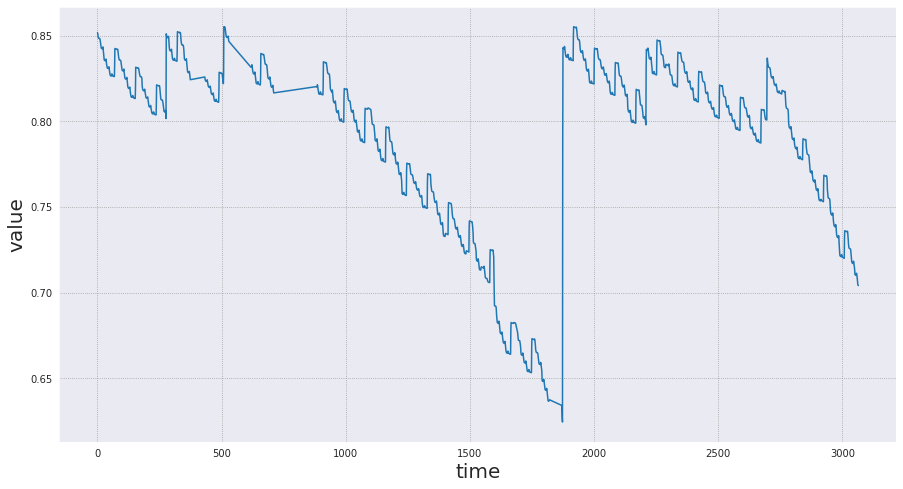

In [154]:
ts_test = train.values

plt.figure(figsize=(15 , 8))

plt.plot(
    ts_test
)

plt.xlabel('time', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.show()

In [155]:
augm = Augmentator()

[[0.85167648]
 [0.85105213]
 [0.84983016]
 ...
 [0.70448748]
 [0.70434365]
 [0.70421894]]


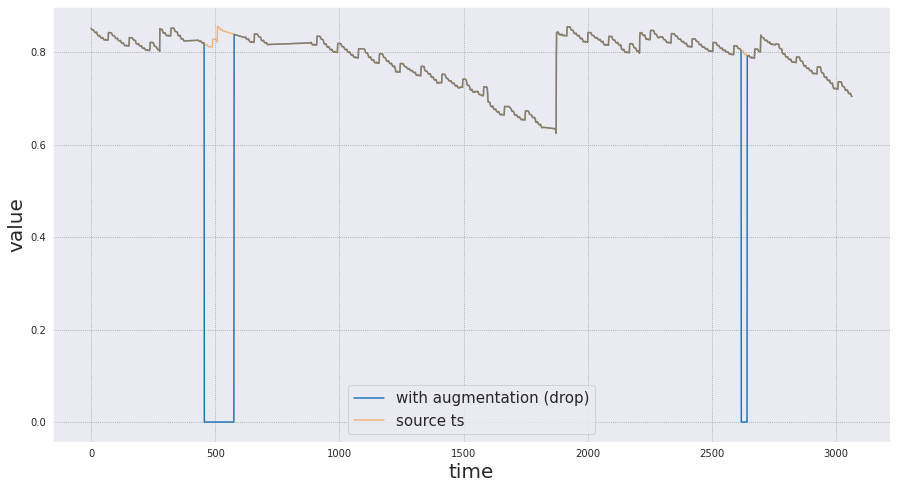

In [156]:
plt.figure(figsize=(15, 8))

drop_train = augm.add_drops(train.values, len_drop=12*2, num_drop=3)

print(drop_train)
plt.plot(
    augm.add_drops(drop_train, len_drop=12*10, num_drop=3),
    label='with augmentation (drop)'
)

plt.plot(
    train.values,
    label='source ts',
    alpha=0.5
)

plt.xlabel('time', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.legend(fontsize=15)
plt.show()

511
511


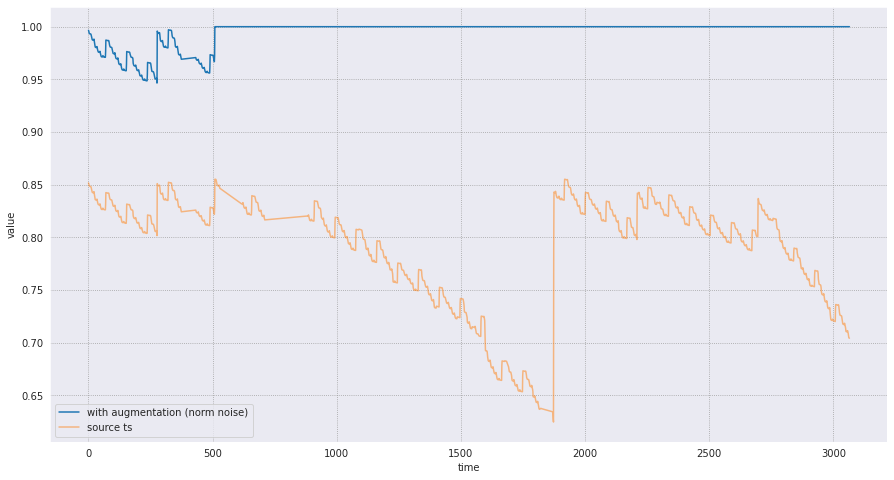

In [157]:
plt.figure(figsize=(15, 8))


orig_plus_const = augm.add_const(train.values)

plt.plot(
    augm.add_const(train.values),
    label='with augmentation (norm noise)'
)

plt.plot(
    train.values,
    label='source ts',
    alpha=0.5
)

plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb49b48b340> has a label of '_value' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


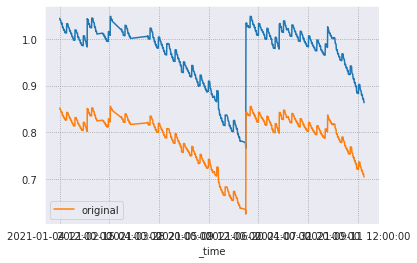

In [158]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise


result = DA_Scaling(train, sigma=0.455)
result["original"] = train
result.plot()
plt.show()

Index(['_value'], dtype='object')
_time
2021-01-04 12:00:00    0.995925
2021-01-04 14:00:00    0.995195
2021-01-04 16:00:00    0.993766
2021-01-04 18:00:00    0.992608
2021-01-04 20:00:00    0.992235
                         ...   
2021-09-16 14:00:00    0.826881
2021-09-16 16:00:00    0.825302
2021-09-16 18:00:00    0.823807
2021-09-16 20:00:00    0.823639
2021-09-16 22:00:00    0.823493
Name: _value, Length: 3066, dtype: float64
1918


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb49eda2f70> has a label of '_value' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


<AxesSubplot:xlabel='_time'>

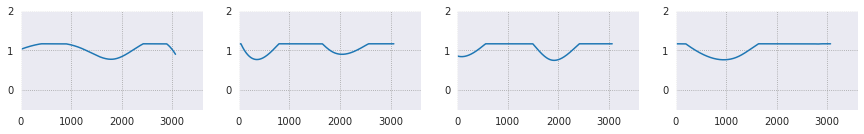

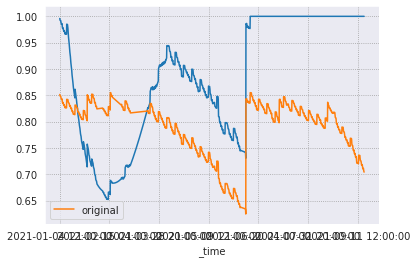

In [184]:
from scipy.interpolate import CubicSpline      # for warping

#Hyperparameters : sigma = STD of the zoom-in/out factor
#Hyperparameters : sigma = STD of the random knots for generating curves
#knot = # of knots for the random curves (complexity of the curves)
#"Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

#"Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"

sigma = 0.2
knot = 4
## This example using cubic splice is not the best approach to generate random curves. 
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1/X.values.max(), scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.clip(np.array([cs_x(x_range)]).transpose(), 0, 1/X.values.max())
    #np.clip(np.random.normal(mean, stddev), minval, maxval)

## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(4):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(GenerateRandomCurves(train, sigma=0.25))
    plt.axis([0,3600,-0.5,2])

def DA_MagWarp(X, sigma, knot):
    return X * GenerateRandomCurves(X, sigma, knot)

result = DA_MagWarp(train, sigma=0.5, knot=4)
print(result.columns)
print(result["_value"])

cut_off = np.argwhere(result["_value"].to_list() == result["_value"].max())[0][0]
print(cut_off)
for i in range(cut_off, len(result["_value"]), 1):
  result["_value"][i] = 1 

result["original"] = train

result.plot()

In [160]:
!pip install transforms3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


                            0         1         2
_time                                            
2021-01-04 12:00:00 -0.465523 -0.412002  0.582147
2021-01-04 14:00:00 -0.465182 -0.411700  0.581721
2021-01-04 16:00:00 -0.464514 -0.411109  0.580885
2021-01-04 18:00:00 -0.463972 -0.410629  0.580208
2021-01-04 20:00:00 -0.463798 -0.410475  0.579991
...                       ...       ...       ...
2021-09-16 14:00:00 -0.386507 -0.342070  0.483336
2021-09-16 16:00:00 -0.385769 -0.341417  0.482413
2021-09-16 18:00:00 -0.385070 -0.340799  0.481539
2021-09-16 20:00:00 -0.384991 -0.340729  0.481441
2021-09-16 22:00:00 -0.384923 -0.340669  0.481356

[3066 rows x 3 columns]


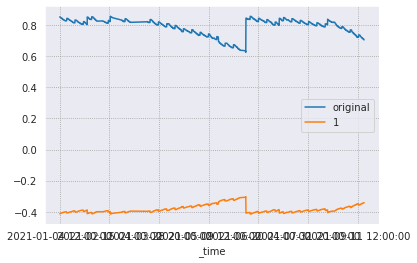

In [182]:
import math

def axangle2mat(axis, angle, is_normalized=False):
    ''' Rotation matrix for rotation angle `angle` around `axis`
    Parameters
    ----------
    axis : 3 element sequence
       vector specifying axis for rotation.
    angle : scalar
       angle of rotation in radians.
    is_normalized : bool, optional
       True if `axis` is already normalized (has norm of 1).  Default False.
    Returns
    -------
    mat : array shape (3,3)
       rotation matrix for specified rotation
    Notes
    -----
    From: http://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle
    '''
    x, y, z = axis

    if not is_normalized:
        n = math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = math.cos(angle); s = math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return np.array([
            [ x*xC+c,   xyC-zs,   zxC+ys ],
            [ xyC+zs,   y*yC+c,   yzC-xs ],
            [ zxC-ys,   yzC+xs,   z*zC+c ]])
    
def DA_Rotation(Y):
    X = Y.copy()
    X['dumy_y'] = 0
    X['dumy_z'] = 0

    axis = np.random.uniform(low=0, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

result = DA_Rotation(train)

print(result)
result["original"] = train.values

result["original"].plot()
result[1].plot()
plt.legend()